# Holt-Winters Exponential Smothing Structure

In [26]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf, month_plot, quarter_plot
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.holtwinters import ExponentialSmoothing, SimpleExpSmoothing

In [27]:
df = pd.read_csv("./data/weekly_customer_complaints.csv", parse_dates=True, index_col="week")
df.head()

,complaints,discount_rate,small_commercial_event,medium_commercial_event,big_commercial_event
week,,,,,
2018-01-01,"1,750",37.26%,1,0,0
2018-01-08,"1,701",35.38%,0,0,0
2018-01-15,"1,711",36.22%,1,0,0
2018-01-22,"1,443",38.33%,1,0,0
2018-01-29,"1,397",36.34%,0,0,0


In [28]:
df.dtypes

complaints                   str
discount_rate                str
small_commercial_event     int64
medium_commercial_event    int64
big_commercial_event       int64
dtype: object

In [29]:
type(df.index)

pandas.DatetimeIndex

In [30]:
df["complaints"] = df["complaints"].apply(
    lambda x: int(x.replace(",", ""))
)

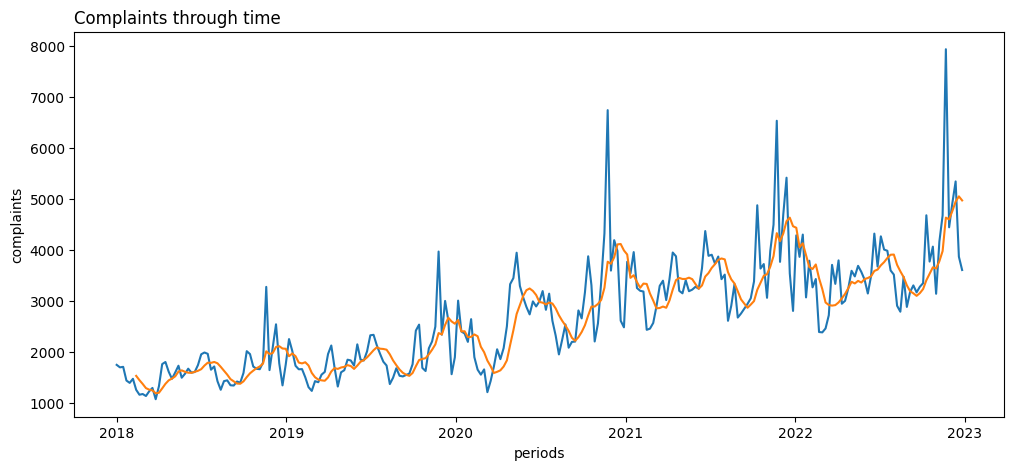

In [31]:
plt.figure(figsize=(12 ,5))
plt.plot(df["complaints"])
plt.plot(df["complaints"].rolling(window=7).mean())
plt.title("Complaints through time", loc="left")
plt.xlabel("periods")
plt.ylabel("complaints")
plt.show()

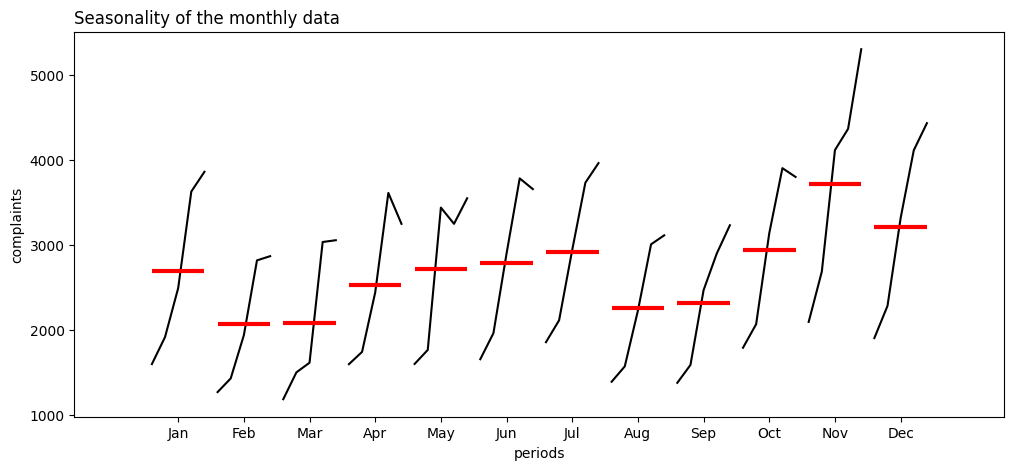

In [32]:
fig, ax = plt.subplots(figsize=(12, 5))
month_plot(df["complaints"].resample(rule="ME").mean() ,ax=ax)
plt.title("Seasonality of the monthly data", loc="left")
plt.xlabel("periods")
plt.ylabel("complaints")
plt.show()

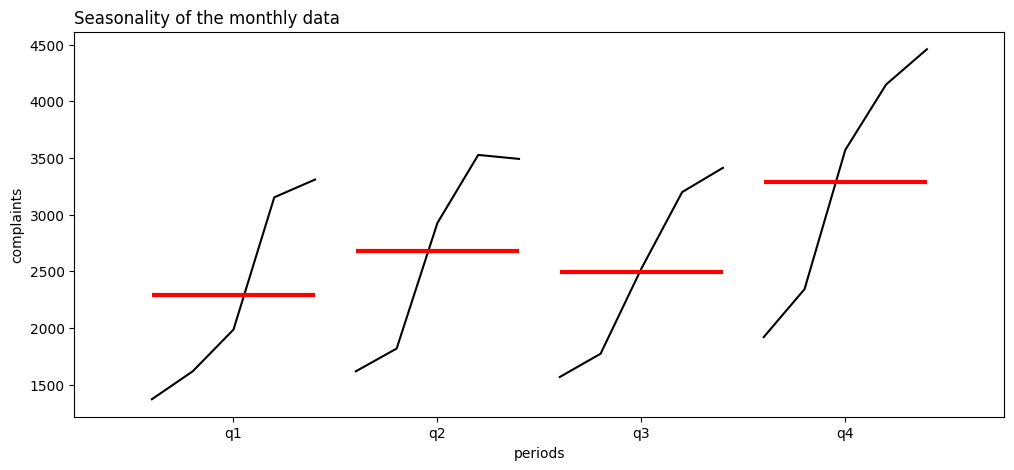

In [33]:
fig, ax = plt.subplots(figsize=(12, 5))
quarter_plot(df["complaints"].resample(rule="QE").mean() ,ax=ax)
plt.title("Seasonality of the monthly data", loc="left")
plt.xlabel("periods")
plt.ylabel("complaints")
plt.show()

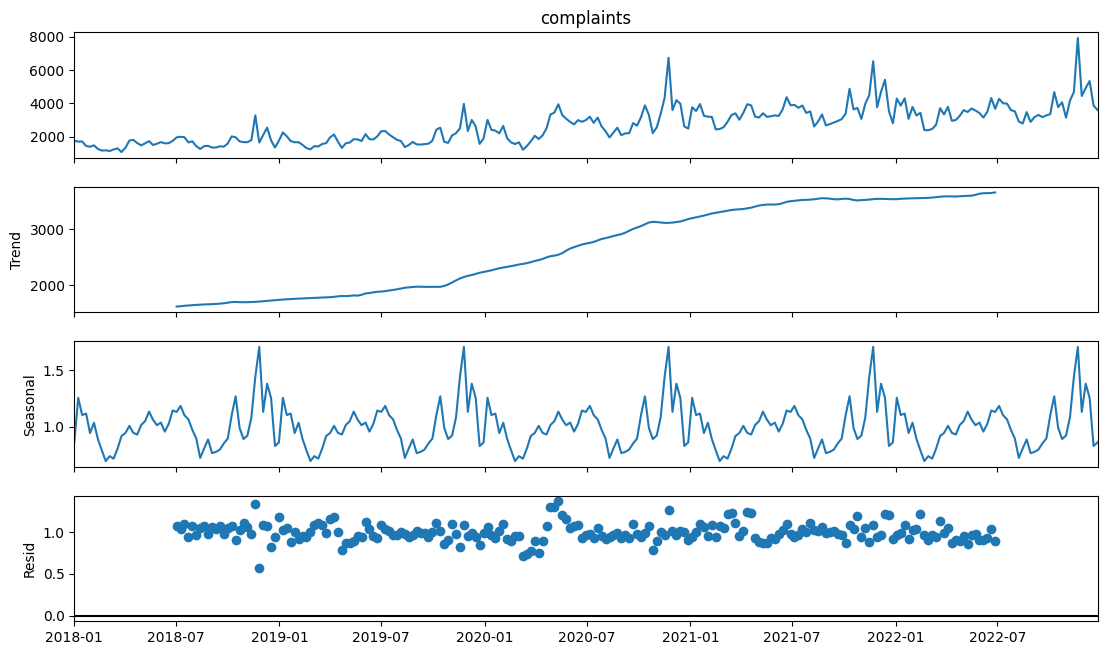

In [34]:
# Seasonal Decomposition

decomposition = seasonal_decompose(
    x=df["complaints"], model="multiplicative", period=52
)
fig = decomposition.plot()
fig.set_size_inches(12, 7)
plt.show()

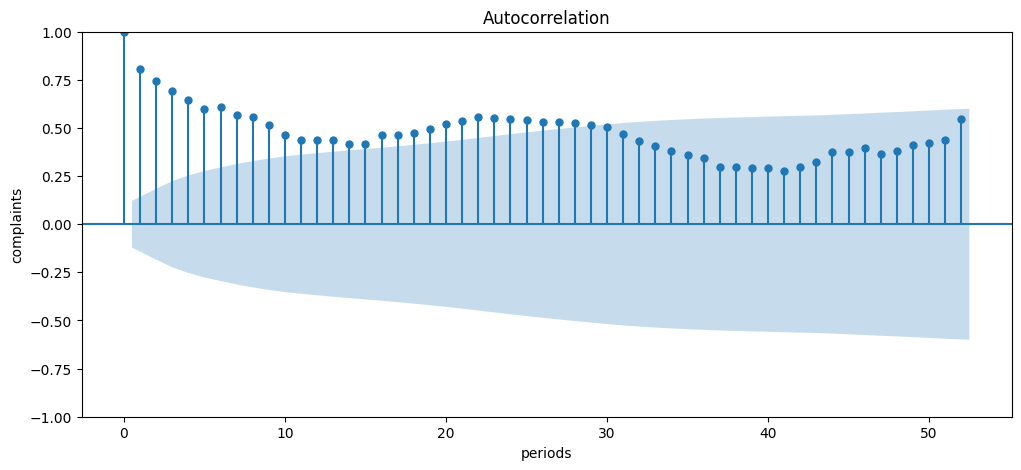

In [35]:
# Autocorrelation

fig, ax = plt.subplots(figsize=(12, 5))
plot_acf(df["complaints"], lags=52, ax=ax)
plt.xlabel("periods")
plt.ylabel("complaints")
plt.show()

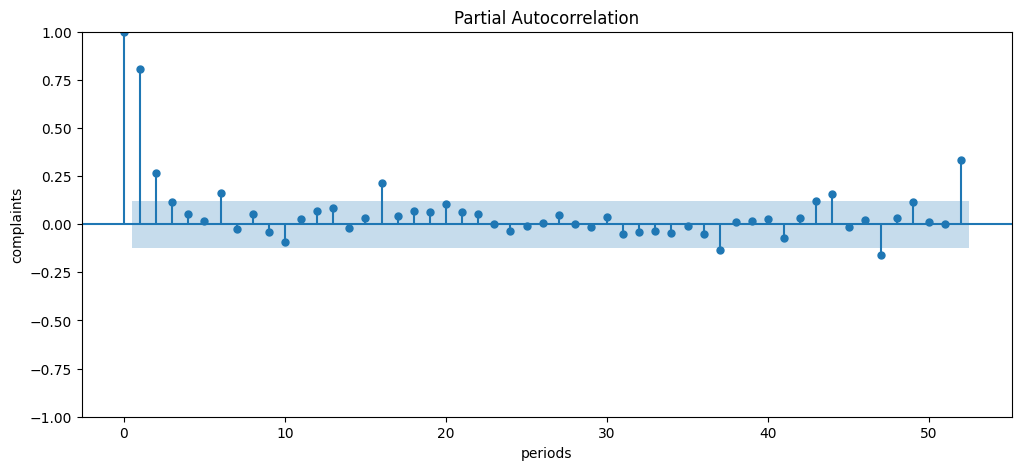

In [36]:
# Partial Autocorrelation

fig, ax = plt.subplots(figsize=(12, 5))
plot_pacf(df["complaints"], lags=52, ax=ax)
plt.xlabel("periods")
plt.ylabel("complaints")
plt.show()

In [37]:
# Time series frequency

df.index

DatetimeIndex(['2018-01-01', '2018-01-08', '2018-01-15', '2018-01-22',
               '2018-01-29', '2018-02-05', '2018-02-12', '2018-02-19',
               '2018-02-26', '2018-03-05',
               ...
               '2022-10-24', '2022-10-31', '2022-11-07', '2022-11-14',
               '2022-11-21', '2022-11-28', '2022-12-05', '2022-12-12',
               '2022-12-19', '2022-12-26'],
              dtype='datetime64[us]', name='week', length=261, freq=None)

In [38]:
df.index.freq = "W-MON"

# Aqui precisa ver no calendário se é W-MON, W-TUE, W-WED....... (baseado na primeira data do DF)

In [39]:
df.index

DatetimeIndex(['2018-01-01', '2018-01-08', '2018-01-15', '2018-01-22',
               '2018-01-29', '2018-02-05', '2018-02-12', '2018-02-19',
               '2018-02-26', '2018-03-05',
               ...
               '2022-10-24', '2022-10-31', '2022-11-07', '2022-11-14',
               '2022-11-21', '2022-11-28', '2022-12-05', '2022-12-12',
               '2022-12-19', '2022-12-26'],
              dtype='datetime64[us]', name='week', length=261, freq='W-MON')

### Traing and Testing Dataset

Goal: Predict the next 13 weeks

In [40]:
periods = 13 # Weeks

df_train = df[:-periods]["complaints"]
df_test = df[-periods:]["complaints"]

### Simple Exponential Smothing

In [41]:
ses_model = SimpleExpSmoothing(df_train).fit()
print(ses_model.summary())

                       SimpleExpSmoothing Model Results                       
Dep. Variable:             complaints   No. Observations:                  248
Model:             SimpleExpSmoothing   SSE                       74355478.081
Optimized:                       True   AIC                           3131.513
Trend:                           None   BIC                           3138.540
Seasonal:                        None   AICC                          3131.678
Seasonal Periods:                None   Date:                 Thu, 29 Jan 2026
Box-Cox:                        False   Time:                         21:02:09
Box-Cox Coeff.:                  None                                         
                       coeff                 code              optimized      
------------------------------------------------------------------------------
smoothing_level            0.5097819                alpha                 True
initial_level              1750.0000                

In [42]:
# Compute with the initial level

df_train.iloc[-1] * 0.5097819 + 1750.0000 # Não atinge o valor de previsão por que é o nível inicial somente. No modelo ele muda dinamicamente internamente

np.float64(3421.5748501)

In [43]:
results_ses = ses_model.forecast(periods)
results_ses

2022-10-03    3236.663473
2022-10-10    3236.663473
2022-10-17    3236.663473
2022-10-24    3236.663473
2022-10-31    3236.663473
2022-11-07    3236.663473
2022-11-14    3236.663473
2022-11-21    3236.663473
2022-11-28    3236.663473
2022-12-05    3236.663473
2022-12-12    3236.663473
2022-12-19    3236.663473
2022-12-26    3236.663473
Freq: W-MON, dtype: float64

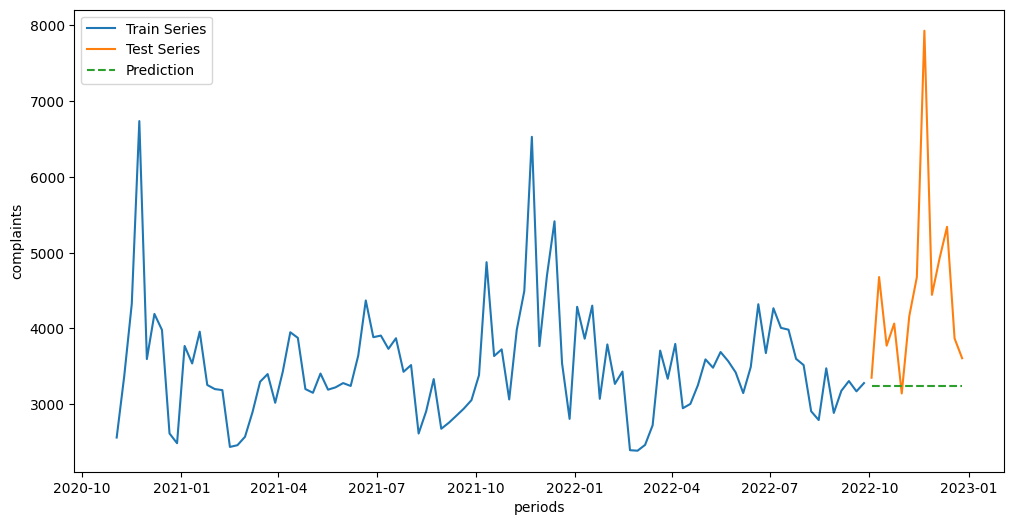

In [44]:
plt.figure(figsize=(12, 6))
plt.plot(df_train[-100:], label="Train Series")
plt.plot(df_test, label="Test Series")
plt.plot(results_ses, label="Prediction", ls="--")
plt.legend()
plt.xlabel("periods")
plt.ylabel("complaints")
plt.show()

### Double Exponential Smothing

In [45]:
des_model = ExponentialSmoothing(endog=df_train, trend="add").fit()
print(des_model.summary())

results_des = des_model.forecast(periods)
results_des

                       ExponentialSmoothing Model Results                       
Dep. Variable:               complaints   No. Observations:                  248
Model:             ExponentialSmoothing   SSE                       74343958.375
Optimized:                         True   AIC                           3135.474
Trend:                         Additive   BIC                           3149.528
Seasonal:                          None   AICC                          3135.823
Seasonal Periods:                  None   Date:                 Thu, 29 Jan 2026
Box-Cox:                          False   Time:                         21:02:09
Box-Cox Coeff.:                    None                                         
                       coeff                 code              optimized      
------------------------------------------------------------------------------
smoothing_level            0.5093880                alpha                 True
smoothing_trend             0.0000

2022-10-03    3248.188426
2022-10-10    3254.078922
2022-10-17    3259.969417
2022-10-24    3265.859912
2022-10-31    3271.750408
2022-11-07    3277.640903
2022-11-14    3283.531399
2022-11-21    3289.421894
2022-11-28    3295.312389
2022-12-05    3301.202885
2022-12-12    3307.093380
2022-12-19    3312.983876
2022-12-26    3318.874371
Freq: W-MON, dtype: float64

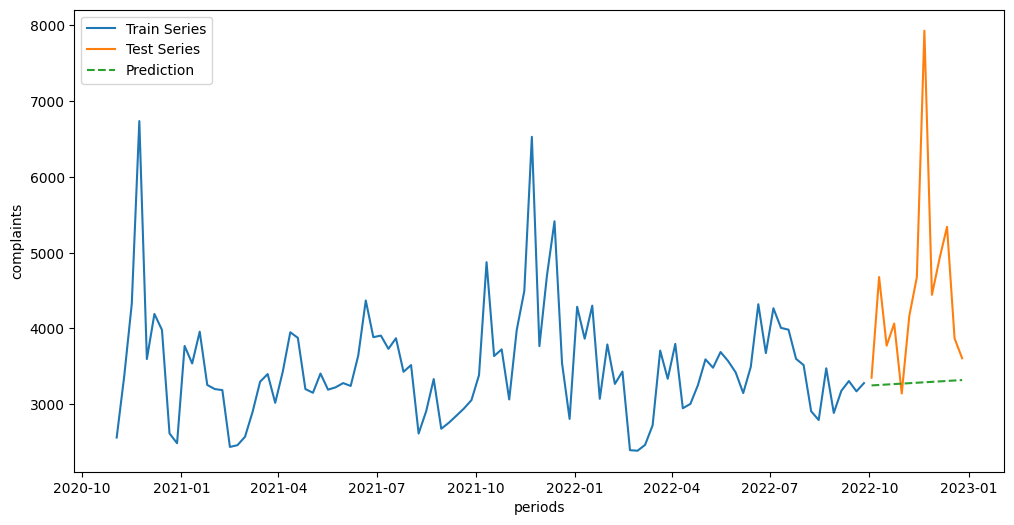

In [46]:
plt.figure(figsize=(12, 6))
plt.plot(df_train[-100:], label="Train Series")
plt.plot(df_test, label="Test Series")
plt.plot(results_des, label="Prediction", ls="--")
plt.legend()
plt.xlabel("periods")
plt.ylabel("complaints")
plt.show()

### Triple Exponential Smothing (Holt-Winters)

In [47]:
tes_model = ExponentialSmoothing(
    endog=df_train, 
    trend="add", 
    seasonal="mul", 
    seasonal_periods=52
).fit()
print(tes_model.summary())

results_tes = tes_model.forecast(periods)
results_tes

                       ExponentialSmoothing Model Results                       
Dep. Variable:               complaints   No. Observations:                  248
Model:             ExponentialSmoothing   SSE                       21600695.729
Optimized:                         True   AIC                           2932.952
Trend:                         Additive   BIC                           3129.704
Seasonal:                Multiplicative   AICC                          2969.164
Seasonal Periods:                    52   Date:                 Thu, 29 Jan 2026
Box-Cox:                          False   Time:                         21:02:09
Box-Cox Coeff.:                    None                                         
                          coeff                 code              optimized      
---------------------------------------------------------------------------------
smoothing_level               0.2491438                alpha                 True
smoothing_trend          

2022-10-03    4041.111424
2022-10-10    5040.624784
2022-10-17    3931.859447
2022-10-24    3531.087941
2022-10-31    3441.012595
2022-11-07    4260.019517
2022-11-14    5352.531269
2022-11-21    7237.950721
2022-11-28    4358.900107
2022-12-05    5316.382668
2022-12-12    5271.229643
2022-12-19    3471.734921
2022-12-26    3336.466558
Freq: W-MON, dtype: float64

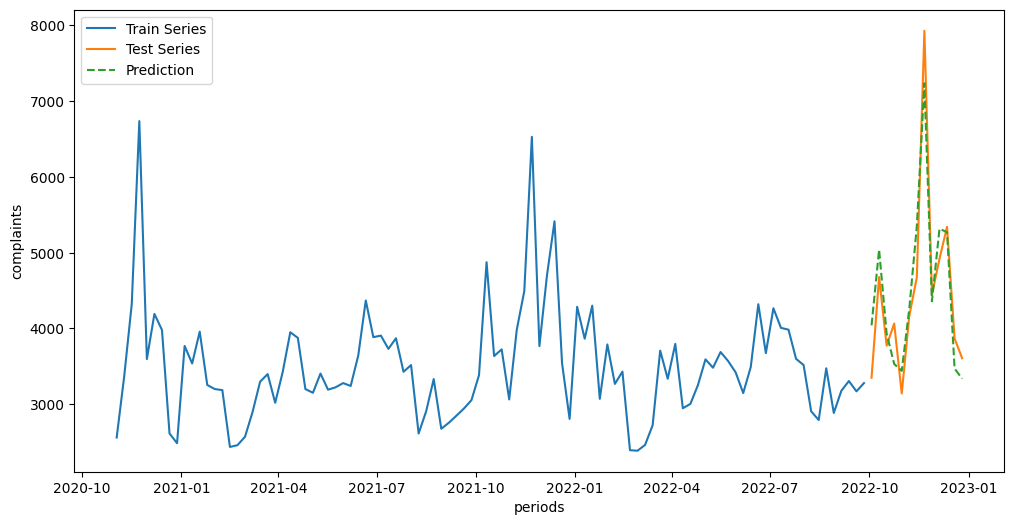

In [48]:
plt.figure(figsize=(12, 6))
plt.plot(df_train[-100:], label="Train Series")
plt.plot(df_test, label="Test Series")
plt.plot(results_tes, label="Prediction", ls="--")
plt.legend()
plt.xlabel("periods")
plt.ylabel("complaints")
plt.show()